In [1]:
import numpy as np
import math 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Normalization # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Input, Embedding , Flatten, Concatenate # type: ignore
from keras.models import Model # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.layers import Dense, Dropout, Activation , BatchNormalization , Dot # type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from wordcloud import WordCloud
from scipy.sparse.linalg import svds
from IPython.display import SVG


### Data visualisation

In [2]:
#gathering data from the dataset

movies = pd.read_csv('dataset/movies.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
movies.columns = ['movie_id' , 'title' , 'genres']
movies.to_pickle('movies.pkl')

ratings = pd.read_csv('dataset/ratings.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
ratings.columns = ['user_id' , 'movie_id' , 'rating' , 'timestamp']

users = pd.read_csv('dataset/users.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
users.columns = ['user_id','gender','age','occupation','zip_code']

In [3]:
print(movies.shape , ratings.shape , users.shape)
movies.head()

(3883, 3) (1000209, 4) (6040, 5)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(movies.isnull().sum())  # Check for missing values in movies DataFrame
print(ratings.isnull().sum())  # Check for missing values in ratings DataFrame
print(users.isnull().sum())  # Check for missing values in users DataFrame

movie_id    0
title       0
genres      0
dtype: int64
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64


In [5]:
print(ratings.duplicated().sum())  # Check for duplicate rating records
print(movies.duplicated().sum())   # Check for duplicate movie records
print(users.duplicated().sum())    # Check for duplicate user records

0
0
0


In [6]:
def extract_year(movie_name):
    try:
        start = movie_name.rindex('(')
        end = movie_name.rindex(')')
        year = int(movie_name[start + 1:end])
        return year
    except (ValueError, IndexError):
        return None

In [7]:
def prepare_years(train_data , max_genres = 5):
    
    title = train_data['title']
    years = [extract_year(name) for name in title]
    
    return (   
        years
    )    

In [8]:
#merging the dataframes movies and ratings on the basis of movie_id aggregate the ratings of each movie
movie_ratings = pd.merge(movies , ratings , on='movie_id')
movie_ratings_mean = movie_ratings.groupby('title').agg({'rating':[np.size,np.mean]})
movie_ratings.head()

,movie_id,title,genres,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [9]:
years = prepare_years(movie_ratings)

movie_ratings = pd.merge(movie_ratings , pd.DataFrame(years , columns=['year']) , left_index=True , right_index=True)
print(movie_ratings.shape)

(1000209, 7)


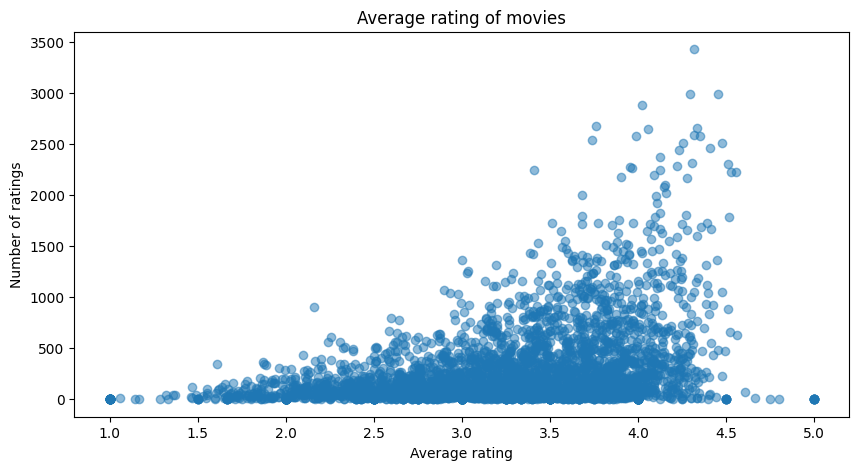

In [10]:
#plot the average rating scatter plot
plt.figure(figsize=(10,5))
plt.title('Average rating of movies')
plt.scatter(movie_ratings_mean[('rating','mean')] , movie_ratings_mean[('rating','size')] , alpha=0.5)
plt.xlabel('Average rating')
plt.ylabel('Number of ratings')
plt.show()


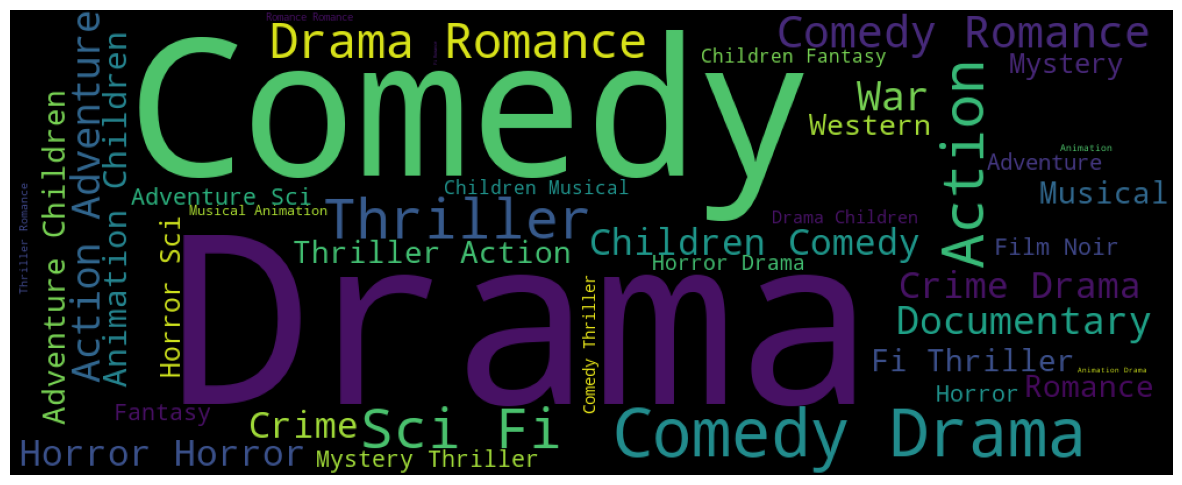

In [11]:
#show the relationship between the average rating and genre
genres = set()
for genre in movies.genres.str.split('|').values:
    genres = genres.union(set(genre))
genres = list(genres)

#display wordcloud of genres
genre_wordcloud = WordCloud(width=1000,height=400).generate(' '.join(movies['genres']))
plt.figure(figsize=(15,10))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

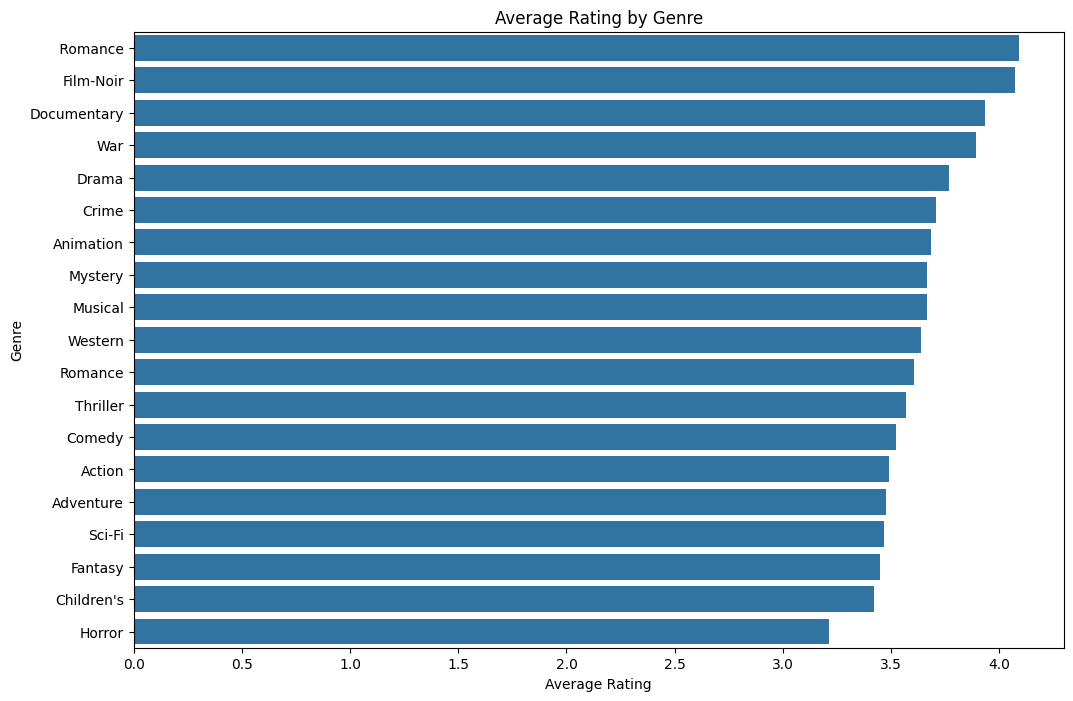

In [12]:
#merge movies and ratings dataframes on the basis of genre and aggregate the ratings of each genre

movies_exploded = movies.copy()
movies_exploded['genre'] = movies_exploded['genres'].str.split('|')
movies_exploded = movies_exploded.explode('genre')

# Step 3: Merge with ratings DataFrame on movieId
merged_data = pd.merge(movies_exploded[['movie_id', 'genre']], ratings[['movie_id', 'rating']], on='movie_id')

# Step 4: Calculate the average rating for each genre
genre_ratings = merged_data.groupby('genre')['rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'average_rating']

genre_ratings_sorted = genre_ratings.sort_values(by='average_rating', ascending=False)

# Display the average rating per genre in a bar chart top to bottom sorted
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='genre', data=genre_ratings_sorted)
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating by Genre')
plt.show()


## Data Preprocessing

In [13]:
#use Label encoding to encode the genres
MoviesWithGenres = movies.copy()
for genre in genres :
  MoviesWithGenres[genre] = MoviesWithGenres.apply(lambda _:int(genre in _.genres), axis = 1)
MoviesWithGenres.head()

,movie_id,title,genres,Crime,Thriller,Musical,Action,Drama,Film-Noir,Documentary,...,Mystery,Sci-Fi,Adventure,Children's,Fantasy,War,Romance,Romance,Western,Horror
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
newratedmovies = movie_ratings.copy()

newratedmovies.userId = newratedmovies.user_id.astype('category').cat.codes.values
newratedmovies.movieId = newratedmovies.movie_id.astype('category').cat.codes.values
newratedmovies.genres = newratedmovies.genres.astype('category').cat.codes.values

newratedmovies.head()
newratedmovies.to_pickle('newratedmovies.pkl')

In [15]:

train_data, test_data = train_test_split(newratedmovies, test_size=0.2, random_state=42)
train_data.head()


,movie_id,title,genres,user_id,rating,timestamp,year
416292,1405,Beavis and Butt-head Do America (1996),154,4375,4,965179742,1996
683230,2527,Westworld (1973),89,2254,4,974594425,1973
2434,2,Jumanji (1995),115,3202,2,968575400,1995
688533,2542,"Lock, Stock & Two Smoking Barrels (1998)",183,710,4,979018202,1998
472584,1676,Starship Troopers (1997),36,4953,2,962641436,1997


## Matrix Factorisation 

In [16]:
def create_model(num_users, num_movies, num_genres, embedding_dim=5):
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    genre_input = Input(shape=(1,), name='genre_input')  # Genre input
    year_input = Input(shape=(1,), name='year_input')  # Release year input

    # User embedding
    user_embedding = Embedding(
        input_dim=num_users,
        output_dim=embedding_dim,
        embeddings_initializer='he_normal',
        name='user_embedding'
    )(user_input)
    user_vector = Flatten()(user_embedding)


    # Movie embedding
    movie_embedding = Embedding(
        input_dim=num_movies,
        output_dim= embedding_dim,
        embeddings_initializer='he_normal',
        name='movie_embedding'
    )(movie_input)
    movie_vector = Flatten()(movie_embedding)


    # Genre embedding
    genre_embedding = Embedding(
        input_dim=num_genres + 1,
        output_dim=embedding_dim ,
        embeddings_initializer='he_normal',
        name='genre_embedding',
        mask_zero=True
    )(genre_input)
    genre_vector = Flatten()(genre_embedding)

    concat = Concatenate()([
        user_vector,
        movie_vector,
        genre_vector,
    ])

    # Dense layers
    x = Dense(100, activation='relu')(concat)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(50, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(20, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(1, activation='relu')(x)

    # Create model
    model = Model(
        inputs=[user_input, movie_input, genre_input],
        outputs=output
    )

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mean_squared_error',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

In [17]:
#find the number of unique users, movies and genres

num_users = max(users['user_id'])+1
num_movies = max(movies['movie_id'])+1
num_genres = max(newratedmovies['genres'])+1


print(num_users, num_movies, num_genres)

# Create model
model = create_model(num_users, num_movies, num_genres, embedding_dim=20)

6041 3953 302


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 20)     │    120,820 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 20)     │     79,060 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_embedding     │ (None, 1, 20)     │      6,060 │ genre_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ genre_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │      6,100 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100)       │        400 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      5,050 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │      1,020 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 218,811 (854.73 KB)

 Trainable params: 218,471 (853.40 KB)

 Non-trainable params: 340 (1.33 KB)

In [19]:
# Prepare data
user_ids = train_data['user_id']
movie_ids = train_data['movie_id']
ratings = train_data['rating']
genres_list = train_data['genres']
years_list = train_data['year']


In [20]:
callbacks = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True)]


history = model.fit(
    x=[user_ids, movie_ids, genres_list],
    y=ratings,
    batch_size=128,
    epochs=50,
    validation_split=0.2,
    validation_data=([test_data['user_id'], test_data['movie_id'], test_data['genres']], test_data['rating']),
    callbacks=callbacks
)

model.save('recommender_model.h5')

Epoch 1/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.3396 - mae: 0.8865 - rmse: 1.1339 - val_loss: 0.8376 - val_mae: 0.7272 - val_rmse: 0.9152
Epoch 2/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.8452 - mae: 0.7290 - rmse: 0.9193 - val_loss: 0.8066 - val_mae: 0.7068 - val_rmse: 0.8981
Epoch 3/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.8070 - mae: 0.7116 - rmse: 0.8983 - val_loss: 0.8036 - val_mae: 0.7109 - val_rmse: 0.8964
Epoch 4/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7877 - mae: 0.7020 - rmse: 0.8875 - val_loss: 0.7839 - val_mae: 0.7061 - val_rmse: 0.8854
Epoch 5/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.7689 - mae: 0.6925 - rmse: 0.8768 - val_loss: 0.7719 - val_mae: 0.6947 - val_rmse: 0.8786
Epoch 6/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7552 - mae: 0.6866 - rmse: 0.8690 - val_loss: 0.7670 - val_mae: 0.6909 - val_rmse: 0.8758
Epoch 7/50
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.7420 

In [21]:
#take the input movie from the user and take a random user from the dataset that has rated the movie
def get_user(movie_id):
    user = newratedmovies[newratedmovies['movie_id'] == movie_id]
    return user['user_id'].values[0]

def get_movie_id(movie_name):
    movie = movies[movies['title'] == movie_name]
    return movie['movie_id'].values[0]
    

In [22]:
def predict_rating(user_id , movie_id):
    user = np.array([user_id])
    movie = np.array([movie_id])
    genre = np.array([newratedmovies[newratedmovies['movie_id'] == movie_id]['genres'].values[0]])
    prediction = model.predict([user, movie, genre])
    return prediction[0][0]

In [23]:
# Load the model weights
model = create_model(num_users, num_movies, num_genres, embedding_dim=20)
model.load_weights('best_model.weights.h5')

# Get the movie ID for the given movie name
movie_name = 'Godfather: Part II, The (1974)'
movie_id = get_movie_id(movie_name)

# Get the user who rated the movie
user_id = get_user(movie_id)

# Get the genres of the specified movie
movie_genres = movies[movies['movie_id'] == movie_id]['genres'].values[0].split('|')  # Assuming genres are "|" separated

# Retrieve user ratings and predict ratings for rated movies
user_ratings = newratedmovies[newratedmovies['user_id'] == user_id][['user_id', 'movie_id', 'rating']]
user_ratings['predicted_rating'] = user_ratings.apply(lambda x: predict_rating(user_id, x['movie_id']), axis=1)
user_ratings = user_ratings.sort_values(by='rating', ascending=False).merge(movies, on='movie_id', how='inner', suffixes=['_u', '_m']).head(20)


# Get movie recommendations
recommended_movies = newratedmovies[newratedmovies['movie_id'].isin(user_ratings['movie_id'])]['movie_id'].unique()
recommendations = pd.DataFrame(recommended_movies, columns=['movie_id'])
recommendations['predictions'] = recommendations.apply(lambda x: predict_rating(user_id, x['movie_id']), axis=1)



# # Filter recommendations by genre similarity
recommendations = recommendations.merge(movies[['movie_id', 'genres']], on='movie_id', how='inner')
recommendations['genre_match'] = recommendations['genres'].apply(lambda g: len(set(g.split('|')) & set(movie_genres)))

# # Sort by genre match (prioritized) and then by prediction score
recommendations = recommendations.sort_values(by=['genre_match', 'predictions'], ascending=[False, False])

# # Display the top 10 recommendations
top_recommendations = recommendations.merge(movies, on='movie_id', how='inner', suffixes=['_u', '_m']).head(10)
top_recommendations[['movie_id', 'title']]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

,movie_id,title
0,1221,"Godfather: Part II, The (1974)"
1,110,Braveheart (1995)
2,1196,Star Wars: Episode V - The Empire Strikes Back...
3,2028,Saving Private Ryan (1998)
4,2571,"Matrix, The (1999)"
5,1610,"Hunt for Red October, The (1990)"
6,733,"Rock, The (1996)"
7,457,"Fugitive, The (1993)"
8,589,Terminator 2: Judgment Day (1991)
9,3256,Patriot Games (1992)


In [24]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 18 = 0.8672


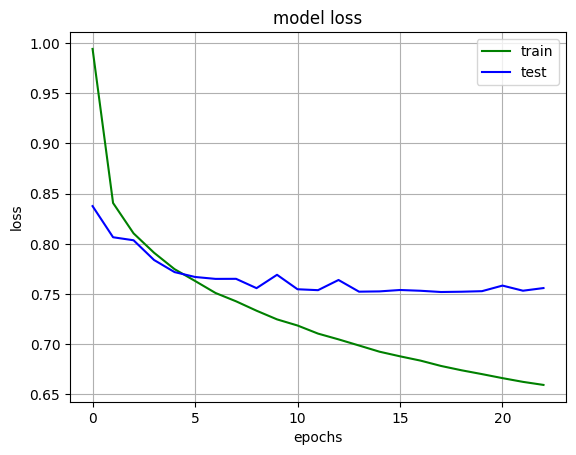

In [25]:
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

In [26]:
movies = pd.read_pickle('movies.pkl')
import requests

def fetch_poster(movie_id):
    # Extract the movie with the given ID
    movie = movies[movies['movie_id'] == movie_id]
    if movie.empty:
        return None

    # Extract the year and title separately
    full_title = movie['title'].values[0]
    year = full_title[-5:-1]  # Extract the year within the last parenthesis
    title = full_title[:-6]  # Extract the title part

    # Check if the title contains a comma followed by 'The', 'A', or 'An'
    if ',' in title:
        parts = title.split(', ')
        print(parts)
        if len(parts) == 2 and parts[1] in ['The ', 'A ', 'An ']:
            #remove white space from parts[1]
            parts[1] = parts[1].strip()
            title = f"{parts[1]} {parts[0]}"  # Rearrange as "The Shining" for "Shining, The"
            
    title.strip()
    year.strip()

    print(title)
    print(year)
    # Search for the movie using the OMDb API
    url = f'http://www.omdbapi.com/?apikey=6787511b&t={title}&y={year}'
    print(url)
    response = requests.get(url)
    data = response.json()
    
    print(data)

    # Get the poster URL from the JSON response
    if "Poster" in data and data["Poster"] != 'N/A':
        return data["Poster"]
    else:
        return None
    
    
movie_id = 39
movie = movies[movies['movie_id'] == movie_id]


print(movie_id)
print(fetch_poster(movie_id=movie_id))

39
Clueless 
1995
http://www.omdbapi.com/?apikey=6787511b&t=Clueless &y=1995
{'Title': 'Clueless', 'Year': '1995', 'Rated': 'PG-13', 'Released': '19 Jul 1995', 'Runtime': '97 min', 'Genre': 'Comedy, Romance', 'Director': 'Amy Heckerling', 'Writer': 'Amy Heckerling', 'Actors': 'Alicia Silverstone, Stacey Dash, Brittany Murphy', 'Plot': "Shallow, rich and socially successful Cher is at the top of her Beverly Hills high school's pecking scale. Seeing herself as a matchmaker, Cher first coaxes two teachers into dating each other.", 'Language': 'English, Spanish', 'Country': 'United States', 'Awards': '6 wins & 12 nominations', 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTgwYjQ1NDktOTcwNi00MWZhLTliYWQtZDg5NjZhY2U5ZTNlXkEyXkFqcGc@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '6.9/10'}, {'Source': 'Metacritic', 'Value': '68/100'}], 'Metascore': '68', 'imdbRating': '6.9', 'imdbVotes': '253,311', 'imdbID': 'tt0112697', 'Type': 'movie', 'DVD': 'N/A', 'BoxOff